# Interpolasi

Install beberapa package berikut ini sebelum menjalankan notebook interpolasi.

```bash
pip install gstools pykrige rasterio
```

kita import package yang diperlukan

In [1]:
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from rasterio.transform import from_origin
import rasterio
from scipy.spatial import cKDTree
import gstools

selanjutnya adalah membuka data. Data yang digunakan secara default berupa tab delimiter. Contoh datanya berikut ini:
```text
lon	lat	val
116.36	2.015	-0.001226
116.36	2.114	-0.002219
116.36	2.214	-0.003445
116.36	2.313	-0.00492
116.36	2.412	-0.006635
...
```

In [2]:
df = pd.read_csv("test.dat", sep="\t"); df

,lon,lat,val
0,116.36,2.015,-0.001226
1,116.36,2.114,-0.002219
2,116.36,2.214,-0.003445
3,116.36,2.313,-0.004920
4,116.36,2.412,-0.006635
...,...,...,...
886,118.96,4.798,-0.009103
887,118.96,4.897,-0.007640
888,118.96,4.996,-0.006187
889,118.96,5.096,-0.004835


ini opsional saja, untuk data coulomb stress, kita akan clip hingga di kisaran -1 hingga 1.

jika tidak ingin melakukan clip data, fungsinya data diubah sebagai berikut:
```python
def fwd(val): return val
```

In [ ]:
def fwd(val):
    return np.clip(val, -1, 1)

sebelum melakukan kriging, terlebih dahulu cek sebaran datanya, apakah data tersebut memiliki tren atau tidak.

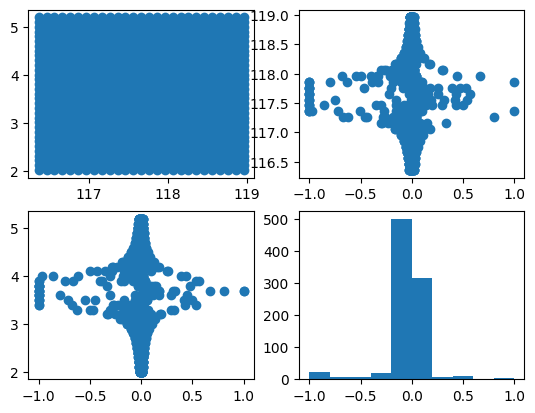

0     -0.001226
1     -0.002219
2     -0.003445
3     -0.004920
4     -0.006635
         ...   
886   -0.009103
887   -0.007640
888   -0.006187
889   -0.004835
890   -0.003631
Name: val, Length: 891, dtype: float64


In [4]:
fig, axs = plt.subplots(2,2)
axs[0,0].scatter(df.lon, df.lat)
axs[0,1].scatter(fwd(df.val), df.lon)
axs[1,0].scatter(fwd(df.val), df.lat)
axs[1,1].hist(fwd(df.val))
plt.show()
print(fwd(df.val))

kita masukkan datanya ke dalam dictionary untuk mempermudah penggunaan variabel kedepannya.

In [5]:
# Data scatter spasial: (x, y, T)
data = {
    "x": df.lon.to_numpy(),
    "y": df.lat.to_numpy(),
    "T": fwd(df.val.to_numpy()),
}

cek terlebih dahulu apakah variogram yang dipilih sudah cocok atau tidak. Ubah bagian ini untuk coba-coba:
```python
model = gstools.Exponential(dim=2)
model = gstools.Gaussian(dim=2)
model = gstools.Spherical(dim=2)
```

/Users/yudhastyawan/miniconda3-arm/envs/pydask/lib/python3.10/site-packages/gstools/covmodel/plot.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


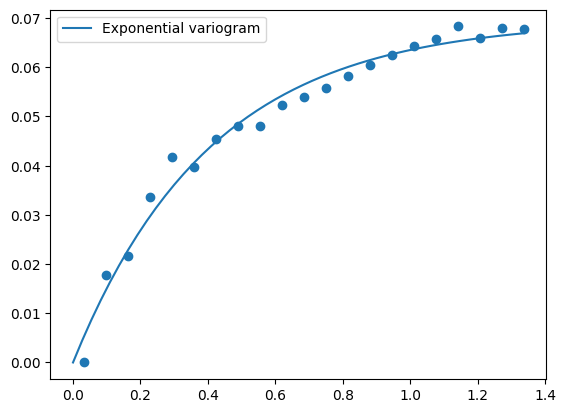

Exponential(dim=2, var=0.0696, len_scale=0.41, nugget=4.17e-18)


In [6]:
model = gstools.Exponential(dim=2)
bin_center, gamma = gstools.vario_estimate(
    pos=[data["x"], data["y"]],
    field=data["T"],
    # estimator="cressie",
)
model.fit_variogram(bin_center, gamma)

# output
ax = model.plot(x_max=max(bin_center))
ax.scatter(bin_center, gamma)
plt.show()
print(model)

waktunya menjalankan kriging dan interpolasi.

In [7]:
# Membuat grid teratur untuk interpolasi
x_grid = np.linspace(min(data["x"]), max(data["x"]), 200)
y_grid = np.linspace(min(data["y"]), max(data["y"]), 200)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Melakukan kriging menggunakan Ordinary Kriging
ok = OrdinaryKriging(
    data["x"], data["y"], data["T"],
    variogram_model=model, # Anda bisa mengganti model variogram (e.g., "spherical", "exponential")
    verbose=True,
    enable_plotting=False,
)
z_mesh, ss = ok.execute("grid", x_grid, y_grid)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using Custom Variogram Model
Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



R-squared: 0.9955079038457918


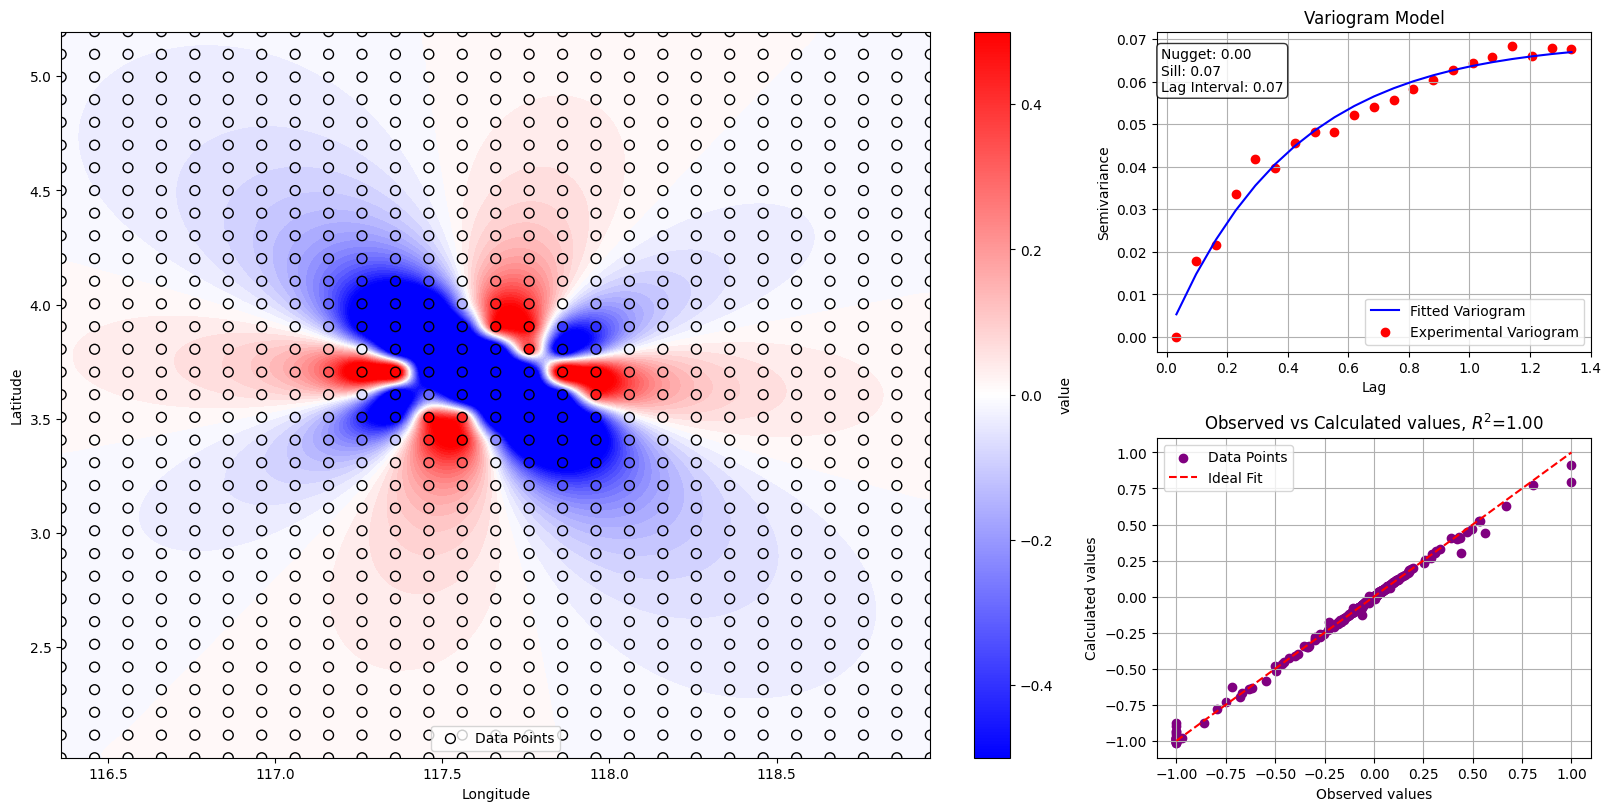

In [12]:
# Membuat plot kontur
vmin = -0.5
vmax = 0.5

# Membuat plot kontur
fig = plt.figure(layout="constrained", figsize=(16, 8))
gs = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0:2,0:2])
contour = ax1.contourf(x_mesh, y_mesh, z_mesh, cmap="bwr", levels=80, vmin=vmin, vmax=vmax)
scatt = ax1.scatter(data["x"], data["y"], c=data["T"], cmap="bwr", edgecolor="k", s=50, label="Data Points", vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatt, label="value")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Menampilkan model variogram
lags = bin_center
semivariance_obs = gamma
fitted_semivariance = model.variogram(bin_center)
nugget = model.nugget
sill = model.sill
lag_interval = lags[1] - lags[0] if len(lags) > 1 else 0

ax2 = fig.add_subplot(gs[0,2])
ax2.plot(lags, fitted_semivariance, label="Fitted Variogram", color="blue")
ax2.scatter(lags, semivariance_obs, label="Experimental Variogram", color="red")
plt.xlabel("Lag")
plt.ylabel("Semivariance")
plt.title("Variogram Model")
plt.legend()
plt.grid()
plt.annotate(f"Nugget: {nugget:.2f}\nSill: {sill:.2f}\nLag Interval: {lag_interval:.2f}",
            xy=(0.01, 0.95), xycoords="axes fraction", verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# Plot korelasi antara data observasi dan data kalkulasi
z_observed = data["T"]
calculated_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))
kdtree = cKDTree(calculated_points)
nearest_indices = kdtree.query(np.column_stack((data["x"], data["y"])))[1]
z_calculated = z_mesh.ravel()[nearest_indices]

# Menghitung R-squared
r_squared = r2_score(z_observed, z_calculated)
print(f"R-squared: {r_squared}")

ax3 = fig.add_subplot(gs[1,2])
ax3.scatter(z_observed, z_calculated, color="purple", label="Data Points")
ax3.plot([min(z_observed), max(z_observed)], [min(z_observed), max(z_observed)], color="red", linestyle="--", label="Ideal Fit")
plt.xlabel("Observed values")
plt.ylabel("Calculated values")
plt.title(f"Observed vs Calculated values, $R^2$={r_squared:.2f}")
plt.legend()
plt.grid()

plt.savefig(f"test_interp_result.png", dpi=330)

# Menyimpan hasil interpolasi dalam bentuk raster .tif
transform = from_origin(x_grid[0], y_grid[-1], x_grid[1] - x_grid[0], y_grid[1] - y_grid[0])
with rasterio.open(
    f"test_kriging_result.tif",
    "w",
    driver="GTiff",
    height=z_mesh.shape[0],
    width=z_mesh.shape[1],
    count=1,
    dtype=z_mesh.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(z_mesh[::-1,:], 1)

plt.show()

selesai!